# Get GTZAN and MusiCNN-MSD

In [1]:
import os
import tensorflow
import torch
import torchaudio
import numpy as np
import essentia.standard as es
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(42)
###############################################################################################

# Please first specify the path of your GTZAN dataset if it is already downloaded in your system.
    # Otherwise leave 'data' or the desired path where we will download the dataset.

GTZAN_path = 'data'
#GTZAN_path = <your_path>

###############################################################################################

# Download dataset from torchaudio
if not os.path.isdir(GTZAN_path):
    os.mkdir(GTZAN_path)
    train_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, download=True, subset='training')
else:
    train_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='training')
val_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='validation')
test_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='testing')

# We download the essentia MSD MusiCNN model
if not os.path.isfile('msd-musicnn-1.pb'):
    !curl -SLO https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.pb

class Essentia_MusiCNNMSD_GTZAN_Dataset(Dataset):
    """ The embeddings of the GTZAN dataset extracted with Essentia-Tensorflow's MusiCNN-MSD model. """
    def __init__(self, GTZAN_dataset, embeddings):
        self.GTZAN_dataset = GTZAN_dataset
        self.embeddings = embeddings
        self.GTZAN_genres = [
            "blues",
            "classical",
            "country",
            "disco",
            "hiphop",
            "jazz",
            "metal",
            "pop",
            "reggae",
            "rock",
        ]
        
    def __len__(self):
        return len(self.GTZAN_dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        inputs = torch.from_numpy(self.embeddings[idx])
        labels = torch.tensor(self.GTZAN_genres.index(self.GTZAN_dataset[idx][2]))
        
        return inputs, labels
# We define a shallow model

class shallowClassifier(nn.Module):
    def __init__(self):
        super(shallowClassifier, self).__init__()
        self.dense1 = nn.Linear(19*200, 100)
        self.dense2 = nn.Linear(100, 10)
        
    def forward(self,x):
        x = x.view(-1, 19*200)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    

# Build embeddings with GTZAN time

In [2]:
# TensorflowPredictMusiCNN expects mono 16kHz sample rate inputs. Resample needed
resample = es.Resample(inputSampleRate=22050, outputSampleRate=16000, quality=0)

# Compute and store the embeddings for each subset
if not os.path.isfile('train_embeddings.npy'):
    i=0
    train_embeddings = []
    for track in train_dataset:
        i+=1
        print('Processing track '+str(i)+' of '+str(len(train_dataset)))
        train_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    np.save('train_embeddings.npy',np.array(train_embeddings))

    val_embeddings = []
    for track in val_dataset:
        val_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    np.save('val_embeddings.npy',np.array(val_embeddings))

    test_embeddings = []
    for track in test_dataset:
        test_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    test_embeddings=np.array(test_embeddings)
    np.save('test_embeddings.npy',np.array(test_embeddings))
else:
    train_embeddings=np.load('train_embeddings.npy')
    val_embeddings=np.load('val_embeddings.npy')
    test_embeddings=np.load('test_embeddings.npy')

Processing track 1 of 443
Processing track 2 of 443
Processing track 3 of 443
Processing track 4 of 443
Processing track 5 of 443
Processing track 6 of 443
Processing track 7 of 443
Processing track 8 of 443
Processing track 9 of 443
Processing track 10 of 443
Processing track 11 of 443
Processing track 12 of 443
Processing track 13 of 443
Processing track 14 of 443
Processing track 15 of 443
Processing track 16 of 443
Processing track 17 of 443
Processing track 18 of 443
Processing track 19 of 443
Processing track 20 of 443
Processing track 21 of 443
Processing track 22 of 443
Processing track 23 of 443
Processing track 24 of 443
Processing track 25 of 443
Processing track 26 of 443
Processing track 27 of 443
Processing track 28 of 443
Processing track 29 of 443
Processing track 30 of 443
Processing track 31 of 443
Processing track 32 of 443
Processing track 33 of 443
Processing track 34 of 443
Processing track 35 of 443
Processing track 36 of 443
Processing track 37 of 443
Processing

Processing track 298 of 443
Processing track 299 of 443
Processing track 300 of 443
Processing track 301 of 443
Processing track 302 of 443
Processing track 303 of 443
Processing track 304 of 443
Processing track 305 of 443
Processing track 306 of 443
Processing track 307 of 443
Processing track 308 of 443
Processing track 309 of 443
Processing track 310 of 443
Processing track 311 of 443
Processing track 312 of 443
Processing track 313 of 443
Processing track 314 of 443
Processing track 315 of 443
Processing track 316 of 443
Processing track 317 of 443
Processing track 318 of 443
Processing track 319 of 443
Processing track 320 of 443
Processing track 321 of 443
Processing track 322 of 443
Processing track 323 of 443
Processing track 324 of 443
Processing track 325 of 443
Processing track 326 of 443
Processing track 327 of 443
Processing track 328 of 443
Processing track 329 of 443
Processing track 330 of 443
Processing track 331 of 443
Processing track 332 of 443
Processing track 333

In [4]:
# Embedding shapes...
train_embeddings[0].shape

(19, 200)

In [5]:
# Embedding types
train_embeddings[0].dtype

dtype('float32')

# Build train loop

In [6]:
def train_test(train_embeddings, val_embeddings, test_embeddings):
    # We compute the distance of the embeddings between all songs in the training set
    emb_distance = np.zeros((len(train_embeddings), len(train_embeddings)))

    for indxA, trackA in enumerate(train_embeddings):
        for indxB, trackB in enumerate(train_embeddings):
            emb_distance[indxA, indxB] = np.linalg.norm(trackA - trackB)        

    embtrain_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(train_dataset, train_embeddings)
    train_loader = torch.utils.data.DataLoader(embtrain_dataset, batch_size=16, shuffle=True, num_workers=4)

    embval_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(val_dataset, val_embeddings)
    val_loader = torch.utils.data.DataLoader(embval_dataset, batch_size=16, shuffle=False, num_workers=4)

    embtest_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(test_dataset, test_embeddings)
    test_loader = torch.utils.data.DataLoader(embtest_dataset, batch_size=16, shuffle=False, num_workers=4)

    model = shallowClassifier()

    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    num_epochs = 200
    train_losses = torch.zeros(num_epochs)
    val_losses = torch.zeros(num_epochs)

    bestloss = 100000.0
    for epoch in range(num_epochs):
        #The train loop
        model.train()
        for inputs, labels in train_loader:
            # Send data to the GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Clear gradient and forward + loss + backward
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses[epoch] += loss.item()
        train_losses[epoch] /= len(train_loader)

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Send data to the GPU
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                outputs = model(inputs) 
                loss = criterion(outputs, labels)

                val_losses[epoch] += loss.item()
            val_losses[epoch] /= len(val_loader)
            scheduler.step(val_losses[epoch])

            # If best epoch, we save parameters
            if val_losses[epoch] < bestloss :
                bestloss = val_losses[epoch]
                torch.save(model.state_dict(), 'model.pth')

        print('Epoch '+str(epoch)+': Train Loss = '+str(train_losses[epoch].item())+'. Val Loss = '+str(val_losses[epoch].item())+'.')
    print('Best validation loss :' + str(bestloss.item()))

    # Finally we compute accuracy with the test set
    model.load_state_dict(torch.load('model.pth'));
    model.eval()
    confusion_matrix = torch.zeros(len(embtrain_dataset.GTZAN_genres), len(embtrain_dataset.GTZAN_genres))
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Send data to the GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Per-class Accuracy
    pclass_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
    return torch.mean(pclass_acc).item()*100

# Train GTZAN_time

In [7]:
baseline = train_test(train_embeddings, val_embeddings, test_embeddings)

Epoch 0: Train Loss = 2.424870729446411. Val Loss = 2.297943592071533.
Epoch 1: Train Loss = 2.139758348464966. Val Loss = 2.0840837955474854.
Epoch 2: Train Loss = 1.914249062538147. Val Loss = 1.9156197309494019.
Epoch 3: Train Loss = 1.7302229404449463. Val Loss = 1.778722882270813.
Epoch 4: Train Loss = 1.5837901830673218. Val Loss = 1.6634392738342285.
Epoch 5: Train Loss = 1.4550983905792236. Val Loss = 1.564780592918396.
Epoch 6: Train Loss = 1.3491288423538208. Val Loss = 1.4800515174865723.
Epoch 7: Train Loss = 1.2539209127426147. Val Loss = 1.4058626890182495.
Epoch 8: Train Loss = 1.1741970777511597. Val Loss = 1.3407841920852661.
Epoch 9: Train Loss = 1.1042193174362183. Val Loss = 1.2840946912765503.
Epoch 10: Train Loss = 1.0480878353118896. Val Loss = 1.2334843873977661.
Epoch 11: Train Loss = 0.9921631813049316. Val Loss = 1.1886451244354248.
Epoch 12: Train Loss = 0.9436535239219666. Val Loss = 1.1486024856567383.
Epoch 13: Train Loss = 0.8994914293289185. Val Loss = 

Epoch 111: Train Loss = 0.24788442254066467. Val Loss = 0.6701147556304932.
Epoch 112: Train Loss = 0.24596083164215088. Val Loss = 0.6701090931892395.
Epoch 113: Train Loss = 0.24580921232700348. Val Loss = 0.670116126537323.
Epoch 114: Train Loss = 0.24779216945171356. Val Loss = 0.670165479183197.
Epoch 115: Train Loss = 0.24604608118534088. Val Loss = 0.6701746582984924.
Epoch 116: Train Loss = 0.246580109000206. Val Loss = 0.6701809763908386.
Epoch 117: Train Loss = 0.24421189725399017. Val Loss = 0.6701965928077698.
Epoch 118: Train Loss = 0.24490077793598175. Val Loss = 0.6701787114143372.
Epoch 119: Train Loss = 0.24515381455421448. Val Loss = 0.670154333114624.
Epoch 120: Train Loss = 0.24534526467323303. Val Loss = 0.670141339302063.
Epoch 121: Train Loss = 0.24695320427417755. Val Loss = 0.6701605916023254.
Epoch 122: Train Loss = 0.24461986124515533. Val Loss = 0.670172929763794.
Epoch 123: Train Loss = 0.24536485970020294. Val Loss = 0.6701720952987671.
Epoch 124: Train Lo

In [8]:
print(baseline)

78.96032929420471


# Baseline is 78.96%

In [272]:
# Now we re-compute embeddings with 

In [273]:
audio = resample(train_dataset[0][0].numpy()[0])

In [274]:
# Melonplaylist mel transform:
def melspectrogram(audio):
    # Computes the mel spectrogram of audio inputs as done in the MelonPlaylist dataset
    windowing = es.Windowing(type='hann', normalized=False, zeroPadding=0)
    spectrum = es.Spectrum()
    melbands = es.MelBands(numberBands=48,
                                   sampleRate=16000,
                                   lowFrequencyBound=0,
                                   highFrequencyBound=16000/2,
                                   inputSize=(512+0)//2+1,
                                   weighting='linear',
                                   normalize='unit_tri',
                                   warpingFormula='slaneyMel',
                                   type='power')
    amp2db = es.UnaryOperator(type='lin2db', scale=2)
    result = []
    for frame in es.FrameGenerator(audio, frameSize=512, hopSize=256,
                                   startFromZero=False):
        spectrumFrame = spectrum(windowing(frame))

        melFrame = melbands(spectrumFrame)
        result.append(amp2db(melFrame))
    return np.array(result)

In [275]:
def adapt_melonInput_musiCNN(melon_sample):
    db2amp = es.UnaryOperator(type='db2lin', scale=2)
    oversampled = np.zeros((len(melon_sample), melon_sample.shape[1]*2)).astype(np.float32)
    for k in range(len(melon_sample)):
        sample = np.log10(1 + (db2amp(melon_sample[k])*10000))
        oversampled[k,:]=np.interp(np.arange(96)/2, np.arange(48), sample)
    return oversampled

In [276]:
melon_sample = melspectrogram(audio)

In [277]:
melon_sample.shape

(1877, 48)

In [278]:
oversampled = adapt_melonInput_musiCNN(melon_sample)

In [279]:
oversampled[0].dtype

dtype('float32')

In [280]:
oversampled.shape

(1877, 96)

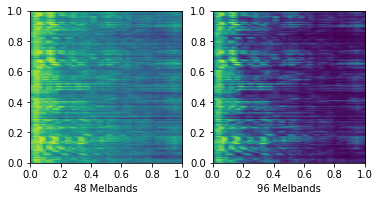

In [281]:
plt.subplot(1,2,1)
plt.imshow(melon_sample, extent=[0, 1, 0, 1])
plt.xlabel('48 Melbands')
plt.subplot(1,2,2)
plt.imshow(oversampled, extent=[0, 1, 0, 1])
plt.xlabel('96 Melbands');

In [282]:
predict_mel = es.TensorflowPredictMusiCNN(graphFilename='msd-musicnn-1.pb', input='model/Placeholder', output='model/dense/BiasAdd')

In [305]:
import essentia
in_pool = essentia.Pool()
patchSize=187
numBands = 96

In [306]:
discard = oversampled.shape[0] % patchSize
batch = np.reshape(oversampled[:-discard,:], [-1, patchSize, numBands])

In [307]:
batch = np.expand_dims(batch, 2)

In [308]:
in_pool.set('model/Placeholder', batch)

In [309]:
out_pool = predict_mel(in_pool)

TypeError: Error cannot convert argument POOL to VECTOR_REAL